In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls -rf /content/drive/MyDrive/7009hdh/chest_xray

.DS_Store  train  test


In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

import shap
from glob import glob


import glob # Used for finding file paths based on patterns, e.g., *.jpg
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator #  Augments image data
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau #reduce the learning rate when training plateaus.
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [4]:
train_df = glob.glob("/content/drive/MyDrive/7009hdh/chest_xray/train/**/*.jpeg")
test_df = glob.glob("/content/drive/MyDrive/7009hdh/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("/content/drive/MyDrive/7009hdh/val/**/*.jpeg")
train_df[:5], test_df[:5]
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5232 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


In [5]:
train_dir = "/content/drive/MyDrive/7009hdh/chest_xray/train"
test_dir = "/content/drive/MyDrive/7009hdh/chest_xray/test/"
validation_dir = "/content/drive/MyDrive/7009hdh/val"
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255.,  # Normalize pixel values
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    rotation_range=30,  # Rotate images by up to 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.3,  # Shear transformation
    zoom_range=0.3,  # Zoom in/out
    channel_shift_range=20.0,  # Randomly shift the color channels
    fill_mode='nearest',  # Fill any newly created pixels after transformations
    brightness_range=[0.5, 1.5]  # Adjust brightness
)


val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5232 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# 1、model 1 CNNS

In [6]:
# Model definition
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# Create the Sequential model
model1 = Sequential()
# Convolutional Neural Networks (CNNs)
model1.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same", input_shape=(224, 224, 3)))  # Increased filters
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu"))  # Increased filters
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))  # Increased dropout to prevent overfitting
model1.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu"))  # Increased filters
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu"))  # Increased filters
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))  # Increased dropout

# Flatten the output of the convolutional layers
model1.add(Flatten())
# Fully connected layers
model1.add(Dense(256, activation="relu"))  # Increased neurons
model1.add(Dropout(0.4))  # Increased dropout
model1.add(Dense(128, activation="relu"))  # Increased neurons
model1.add(Dense(64, activation="relu"))  # Increased neurons
# Output layer (binary classification)
model1.add(Dense(1, activation="sigmoid"))
# Summary of the model architecture
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,282,561 (104.07 MB)

 Trainable params: 27,282,561 (104.07 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model1.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])
#Root Mean Square Propagation 根均方传播
early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True)
# 模型训练
history = model1.fit(train_set, epochs=20,
                     validation_data=validation_set,
                     steps_per_epoch=100,
                     callbacks=[early_stopping_callbacks])



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



100/100 ━━━━━━━━━━━━━━━━━━━━ 610s 5s/step - accuracy: 0.7071 - loss: 0.7654 - val_accuracy: 0.5000 - val_loss: 0.8112
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.7330 - loss: 0.5742 - val_accuracy: 0.5625 - val_loss: 0.6135
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.7302 - loss: 0.4953 - val_accuracy: 0.6250 - val_loss: 0.8582
Epoch 4/20
 24/100 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.7802 - loss: 0.3751

/usr/lib/python3.11/contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 359ms/step - accuracy: 0.7819 - loss: 0.3888 - val_accuracy: 0.6875 - val_loss: 0.4866
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7763 - loss: 0.4288 - val_accuracy: 0.6250 - val_loss: 0.7879
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.8177 - loss: 0.4059 - val_accuracy: 0.6875 - val_loss: 0.5680
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8446 - loss: 0.3601 - val_accuracy: 0.6250 - val_loss: 0.6187
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.8190 - loss: 0.4511 - val_accuracy: 0.6875 - val_loss: 0.5574
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 790ms/step - accuracy: 0.8234 - loss: 0.4273 - val_accuracy: 0.6250 - val_loss: 0.9626
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 595ms/step - accuracy: 0.8452 - loss: 0.3427 - val_accuracy: 0.5625 - val_loss: 0.8306
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 477ms/step - accuracy: 0.8483 - loss: 0.3195 - val_acc

In [11]:


scores = model1.evaluate(test_set)  # Evaluate the model on the test_set generator
print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

# The rest of the code can remain the same
test_loss, test_accuracy = model1.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.7841 - loss: 0.4576

loss: 46.268%

compile_metrics: 79.006%
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.8103 - loss: 0.4411
The testing accuracy is:  79.00640964508057 %


In [21]:

# 获取测试集的真实标签和预测标签
test_labels = test_set.classes
test_predictions = model1.predict(test_set, steps=50)
test_predictions = (test_predictions > 0.5).astype('int32')

# 计算F1值
test_f1_score2 = f1_score(test_labels, test_predictions)
print("The testing F1 score of VGG16 model is: ", test_f1_score2 )

# 计算准确度
test_accuracy_score2 = accuracy_score(test_labels, test_predictions)
print("The testing accuracy score of VGG16 model is: ", test_accuracy_score2 * 100, "%")
test_loss, test_accuracy = model1.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step
The testing F1 score of VGG16 model is:  0.540084388185654
The testing accuracy score of VGG16 model is:  47.59615384615385 %


/usr/lib/python3.11/contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7731 - loss: 0.4737
The testing accuracy is:  79.00640964508057 %


/usr/lib/python3.11/contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



# 2、model 2 VGG16

In [8]:
# VGG16 model
# VGG16模型

from tensorflow.keras.callbacks import EarlyStopping

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 冻结基础模型的层
for layer in base_model.layers:
    layer.trainable = False

# 扩展模型
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

# 模型编译
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

# 数据生成器
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    channel_shift_range=20.0,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode="binary", batch_size=16, target_size=(224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode="binary", batch_size=16, target_size=(224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode="binary", batch_size=16, target_size=(224, 224))

# 早停回调

early_stopping_callbacks = EarlyStopping(patience=15, restore_best_weights=True)

# 模型训练
history2 = model2.fit(train_set, epochs=20, validation_data=validation_set, steps_per_epoch=100, callbacks=[early_stopping_callbacks])



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 355ms/step - accuracy: 0.7212 - loss: 1.0958 - val_accuracy: 0.6250 - val_loss: 0.5869
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 353ms/step - accuracy: 0.7981 - loss: 0.4275 - val_accuracy: 0.8750 - val_loss: 0.3497
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 367ms/step - accuracy: 0.8277 - loss: 0.3672 - val_accuracy: 0.9375 - val_loss: 0.3390
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8589 - loss: 0.3150 - val_accuracy: 0.9375 - val_loss: 0.3327
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step - accuracy: 0.8607 - loss: 0.3308 - val_accuracy: 0.8750 - val_loss: 0.3079
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 354ms/step - accuracy: 0.8611 - loss: 0.3038 - val_accuracy: 0.9375 - val_loss: 0.2966
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - accuracy: 0.8484 - loss: 0.3346 - val_accuracy: 0.9375 - val_loss: 0.3186
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8633 - loss: 0.310

In [19]:
# 模型评估
test_loss2, test_accuracy2 = model2.evaluate(test_set, steps=50)
print("The testing loss of VGG16 model is: ", test_loss2)
print("The testing accuracy of VGG16 model is: ", test_accuracy2 * 100, "%")

# 获取测试集的真实标签和预测标签
test_labels = test_set.classes
test_predictions = model2.predict(test_set, steps=50)
test_predictions = (test_predictions > 0.5).astype('int32')

# 计算F1值
test_f1_score2 = f1_score(test_labels, test_predictions)
print("The testing F1 score of VGG16 model is: ", test_f1_score2 )

# 计算准确度
test_accuracy_score2 = accuracy_score(test_labels, test_predictions)
print("The testing accuracy score of VGG16 model is: ", test_accuracy_score2 * 100, "%")

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8946 - loss: 0.2778
The testing loss of VGG16 model is:  0.26772642135620117
The testing accuracy of VGG16 model is:  90.86538553237915 %


/usr/lib/python3.11/contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step
The testing F1 score of VGG16 model is:  0.6329442282749675
The testing accuracy score of VGG16 model is:  54.64743589743589 %


# 3、model 3 EfficientNetB3

In [14]:
from tensorflow.keras.applications import EfficientNetB3

# Replace ResNet50V2 with EfficientNetB3
base_model2 = EfficientNetB3(weights="imagenet",  # Use pre-trained weights from ImageNet
                             input_shape=(224, 224, 3),
                             pooling="max",  # Global average pooling
                             include_top=False)  # Exclude the fully connected layers

# Freeze the layers of EfficientNetB3 for transfer learning
for layer in base_model2.layers:
    layer.trainable = False

model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# base_model2.summary()

# %%time

history = model3.fit(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 442ms/step - accuracy: 0.6854 - loss: 0.7729 - val_accuracy: 0.5000 - val_loss: 0.9852
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 342ms/step - accuracy: 0.7464 - loss: 0.5694 - val_accuracy: 0.5000 - val_loss: 1.1014
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 349ms/step - accuracy: 0.6806 - loss: 0.6687 - val_accuracy: 0.5000 - val_loss: 0.8675
Epoch 4/20
 24/100 ━━━━━━━━━━━━━━━━━━━━ 22s 293ms/step - accuracy: 0.7667 - loss: 0.5739

/usr/lib/python3.11/contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7559 - loss: 0.5850 - val_accuracy: 0.5000 - val_loss: 0.8072
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 350ms/step - accuracy: 0.7322 - loss: 0.5984 - val_accuracy: 0.5000 - val_loss: 0.7977
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 349ms/step - accuracy: 0.7512 - loss: 0.5715 - val_accuracy: 0.5000 - val_loss: 0.7985
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 350ms/step - accuracy: 0.7299 - loss: 0.5909 - val_accuracy: 0.5000 - val_loss: 0.8411
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7763 - loss: 0.5489 - val_accuracy: 0.5000 - val_loss: 0.8320
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 353ms/step - accuracy: 0.7400 - loss: 0.5837 - val_accuracy: 0.5000 - val_loss: 0.8093
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 349ms/step - accuracy: 0.7291 - loss: 0.6024 - val_accuracy: 0.5000 - val_loss: 0.8324
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 348ms/step - accuracy: 0.7493 - loss: 0.5665 - val_a

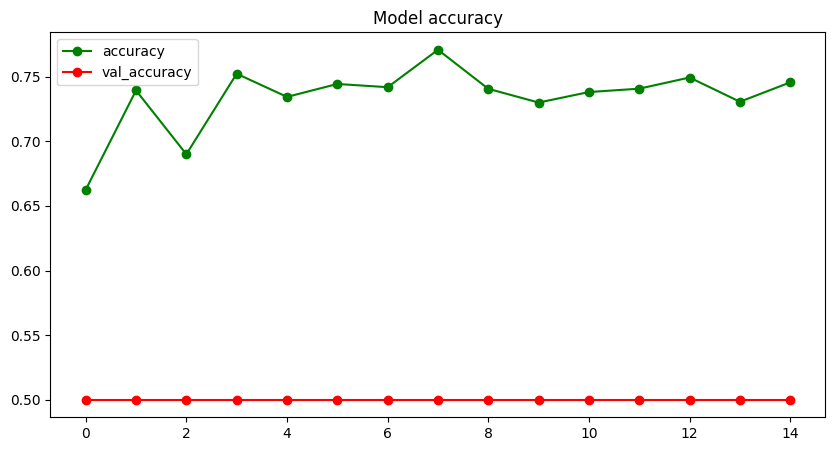

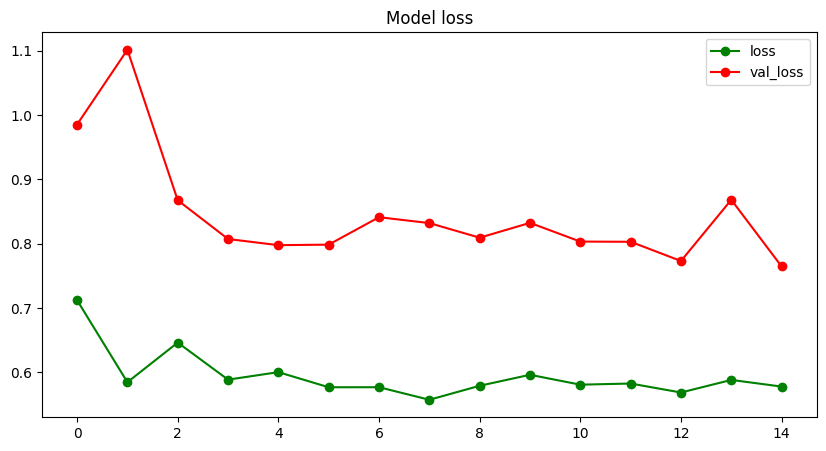

In [15]:
# Visualize performance of model3
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

In [20]:
# Evaluate model3 on the test set

#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))


test_loss, test_accuracy = model3.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

# 获取测试集的真实标签和预测标签
test_labels = test_set.classes
test_predictions = model3.predict(test_set, steps=50)
test_predictions = (test_predictions > 0.5).astype('int32')

# 计算F1值
test_f1_score2 = f1_score(test_labels, test_predictions)
print("The testing F1 score of VGG16 model is: ", test_f1_score2 )


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.6016 - loss: 0.8222
The testing accuracy is:  62.5 %
The testing loss is:  78.46057415008545 %


/usr/lib/python3.11/contextlib.py:158: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step
The testing F1 score of VGG16 model is:  0.7692307692307693


# 4、Grad-CAM(XAI)

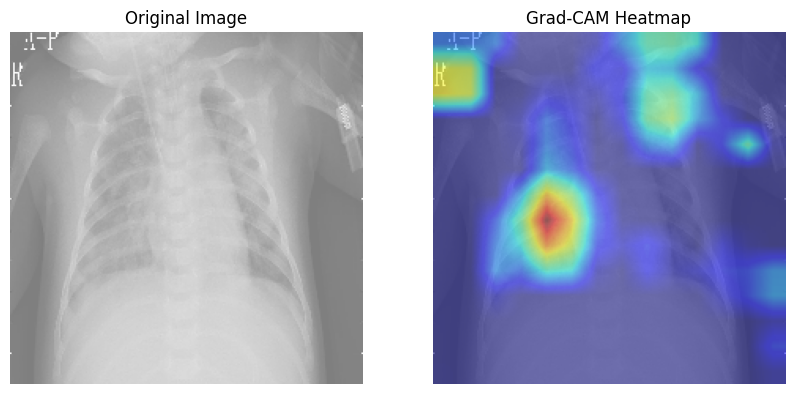

In [31]:
# Grad-CAM implementation

from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Grad-CAM Implementation Grad-CAM 实施
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.model.eval()

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        x = x.to(device)
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        output[:, class_idx].backward()
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activation).sum(dim=1).squeeze().detach().cpu().numpy()

        # Normalize CAM
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam / cam.max()
        return cam

# Visualize Grad-CAM results  可视化 Grad-CAM 结果
def visualize_gradcam(model, dataloader, target_layer):
    grad_cam = GradCAM(model, target_layer)

    # Get a single batch of images and labels
    images, labels = next(iter(dataloader))
    image = images[0]  # Take the first image in the batch  #
    label = labels[0].item()  # Get the label  #

    # Convert the image to a PyTorch tensor
    image = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension
    # Apply Grad-CAM  应用
    cam = grad_cam(image)

    # Apply Grad-CAM  应用
    # cam = grad_cam(image.unsqueeze(0))

    # Convert the image back to a format suitable for visualization
    inv_transform = transforms.Compose([
        transforms.Normalize(mean=[-0.5 / 0.5], std=[1 / 0.5]),
        transforms.ToPILImage()
    ])
    original_image = inv_transform(image.cpu().squeeze(0)) # Remove batch dimension before applying ToPILImage

    # Plot the original image and the heatmap 绘制原始图像和热图
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(original_image)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis("off")

    plt.show()

# # Visualize Grad-CAM results for the validation set 可视化验证集的 Grad-CAM 结果

# 加载 VGG16 模型（不修改模型结构）

# Load the VGG16 model (do not modify the model structure)
vgg_model = models.vgg16(pretrained=True)
# Modify the last layer to match your number of classes (binary classification in this case)
num_ftrs = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_ftrs, 1)  # Replace with your number of classes
vgg_model = vgg_model.to(device)
vgg_model.eval()  # Set to evaluation mode

# Find the last convolutional layer in the features module
last_conv_layer = next(layer for layer in reversed(list(vgg_model.features.children())) if isinstance(layer, nn.Conv2d))

# Visualize Grad-CAM results for the validation set 可视化验证集的 Grad-CAM 结果
visualize_gradcam(vgg_model, validation_set, last_conv_layer)

# 5、LIME(XAI)

In [34]:
!pip install lime

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.



  0%|          | 0/1000 [00:00<?, ?it/s]

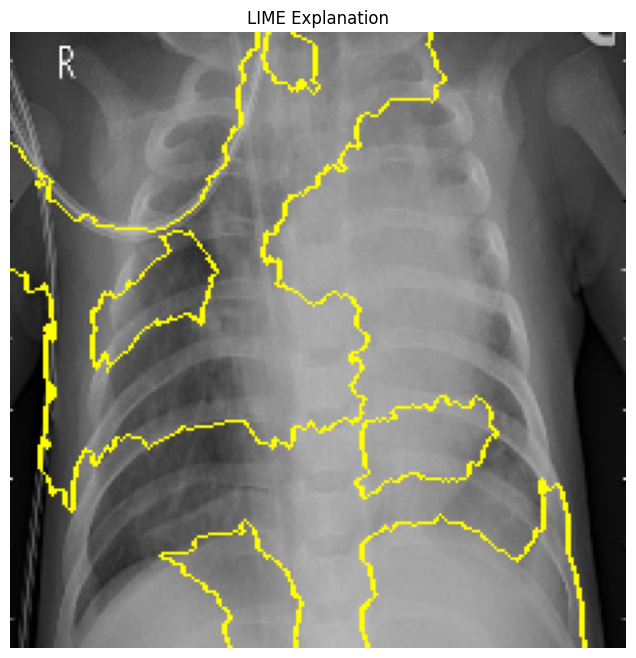

In [36]:

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import cv2
from torchvision import transforms, models
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 加载 VGG16 模型（不修改模型结构）
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[6] = nn.Linear(4096, 1)
vgg_model = vgg_model.to(device)
vgg_model.eval()  # 设置为评估模式


# 定义图像预处理函数
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image_lime(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    img_tensor = transform(img_resized).unsqueeze(0)
    return img_resized, img_tensor

# 加载指定图像
img_path = "/content/drive/MyDrive/7009hdh/chest_xray/test/PNEUMONIA/person100_bacteria_479.jpeg"
original_img, sample_img = preprocess_image_lime(img_path)

# 定义 LIME Explainer
explainer = lime_image.LimeImageExplainer()

# 定义预测函数（LIME需要输入numpy格式数据）
def batch_predict(images):
    vgg_model.eval()
    images = torch.stack([transform(image).to(device) for image in images], dim=0)
    with torch.no_grad():
        outputs = vgg_model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
    return np.concatenate((1 - probs, probs), axis=1)


# 解释图像预测
explanation = explainer.explain_instance(
    original_img,
    batch_predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)


# 可视化 LIME 解释结果
from skimage.color import label2rgb

# 获取正类别（1）的解释
temp, mask = explanation.get_image_and_mask(
    label=1,
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.figure(figsize=(8, 8))
plt.title("LIME Explanation")
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()

